In [1]:
from keras.layers import Input, Dense, Reshape, Flatten, Activation
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D, MaxPooling2D
from keras.models import Sequential, Model
from keras.optimizers import Adam
from sklearn.utils import shuffle
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image

Using TensorFlow backend.


# Set Parameters

In [2]:
# Folder containing dataset
data_path = r'D:\Downloads\cats-faces-64x64-for-generative-models\cats'

# Folder where you want to save to model as well as generated samples
model_path = r"C:\Users\Vee\Desktop\python\GAN\pca_new"

# How many epochs between saving your model
interval = 5

# How many epochs to run the model
epoch = 5

# How many images to train at one time. If batch size is less than 8, alter the save_img function to plot less images
# Ideally this number would be a factor of the size of your dataset
batch = 181

# How many convolutional filters for each convolutional layer of the generator and the discrminator
conv_filters = 64

# Size of kernel used in the convolutional layers
kernel = (5,5)

# Boolean flag, set to True if the data has pngs to remove alpha layer from images
png = False

# Create Deep Convolutional GAN Class

In [3]:
class DCGAN():
    
    # Initialize parameters, generator, and discriminator models
    def __init__(self):
        
        # Set dimensions of the output image
        self.img_rows = 64
        self.img_cols = 64
        self.channels = 3
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        
        # Set dimensions of the input noise
        self.latent_dim = 512
        
        # Chose optimizer for the models
        optimizer = Adam(0.0002, 0.5)

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy',
            optimizer=optimizer,
            metrics=['accuracy'])

        # Build the generator
        self.generator = self.build_generator()
        generator = self.generator

        # The generator takes noise as input and generates imgs
        z = Input(shape=(self.latent_dim,))
        img = self.generator(z)

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The discriminator takes generated images as input and determines validity
        valid = self.discriminator(img)

        # The combined model  (stacked generator and discriminator)
        # Trains the generator to fool the discriminator
        self.combined = Model(z, valid)
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)
    
    # load data from specified file path
    def load_data(self):
    
        # Initializing arrays for data and image file paths
        data = []
        paths = []
        
        # Get the file paths of all jpg files in this folder
        for r, d, f in os.walk(data_path):
            for file in f:
                if '.jpg' in file:
                    paths.append(os.path.join(r, file))

        # For each file add it to the data array
        for path in paths:
            
            img = Image.open(path)
            img = np.array(img.resize((self.img_rows, self.img_cols)))
            
            # Remove alpha layer if imgaes are PNG
            if(png):
                img = img[...,:3]
                
            data.append(img)
        
        #Reshaping data to be two dimensional for Principal Component Analysis
        img_vector = np.array(data).reshape(len(data), self.img_rows * self.img_cols * self.channels)/255
        
        #Keep the first 512 eigenvectors of the covariance matrix of the img_vector
        pca = PCA(n_components=512).fit(img_vector)
        pca_data = pca.transform(img_vector)
        
        # Return x_train reshaped to two dimensions and Y_train reshaped to 4 dimensions
        x_train = pca_data.reshape(len(pca_data), 512)
        y_train = np.array(data)
        y_train = y_train.reshape(len(data),64,64,3)
        
        # Shuffle indexes of data
        X_shuffle, Y_shuffle = shuffle(x_train, y_train)
        
        return X_shuffle, Y_shuffle
    
    # Define Generator model. There are 5 convolutional filters, upsampling from (8x8x8) to (64x64x3)
    def build_generator(self):

        model = Sequential()
        
        # Input Layer
        model.add(Dense(8 * 8 * 8, input_dim=self.latent_dim))
        model.add(Reshape((8, 8, 8)))
        
        # 1st Convolutional Layer
        model.add(Conv2D(conv_filters, kernel_size=kernel, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        
        # Upsample the data (8x8 to 16x16)
        model.add(UpSampling2D())
        
        # 2nd Convolutional Layer
        model.add(Conv2D(conv_filters, kernel_size=kernel, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        
        # Upsample the data (16x16 to 32x32)
        model.add(UpSampling2D())

        # 3rd Convolutional Layer
        model.add(Conv2D(conv_filters, kernel_size=kernel, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        
        # Upsample the data (32x32 to 64x64)
        model.add(UpSampling2D())

        # 4th Convolutional Layer
        model.add(Conv2D(conv_filters, kernel_size=kernel, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        
        # 5th Convolutional Layer (Output Layer)
        model.add(Conv2D(3, kernel_size=kernel, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.summary()

        noise = Input(shape=(self.latent_dim,))
        img = model(noise)

        return Model(noise, img)

    # Define Discriminator model. There are 5 convolutional filters, downsampling from (64x64x3) to (1) scalar prediction
    def build_discriminator(self):

        model = Sequential()

        # Input Layer
        model.add(Conv2D(conv_filters, kernel_size=kernel, input_shape=self.img_shape,activation = "relu", padding="same"))
        
        # Downsample the data (64x64 to 32x32)
        model.add(MaxPooling2D(pool_size=(2, 2)))
        
        # 1st Convolutional Layer
        model.add(Conv2D(conv_filters, kernel_size=kernel, activation='relu', padding="same"))
        
        # Downsample the data (32x32 to 16x16)
        model.add(MaxPooling2D(pool_size=(2, 2)))
        
        # 2nd Convolutional Layer
        model.add(Conv2D(conv_filters, kernel_size=kernel, activation='relu', padding="same"))
        
        # Downsample the data (16x16 to 8x8)
        model.add(MaxPooling2D(pool_size=(2, 2)))
        
        # 3rd Convolutional Layer
        model.add(Conv2D(conv_filters, kernel_size=kernel, activation='relu', padding="same"))
        
        # 4th Convolutional Layer
        model.add(Conv2D(conv_filters, kernel_size=kernel, activation='relu', padding="same"))
        
        # 5th Convolutional Layer
        model.add(Conv2D(conv_filters, kernel_size=kernel, activation='relu', padding="same"))
        
        model.add(Flatten())
        
        # Output Layer
        model.add(Dense(1, activation='sigmoid'))

        model.summary()

        img = Input(shape=self.img_shape)
        validity = model(img)

        return Model(img, validity)
    
    # Train the Generative Adversarial Network
    def train(self, epochs, batch_size, save_interval):

        # Load the dataset
        X_train, Y_train = self.load_data()
        
        # Normalizing data to be between 0 and 1
        Y_train = Y_train/255

        # Adversarial ground truths
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))
        
        # Placeholder arrays for Loss function values
        g_loss_epochs = np.zeros((epochs, 1))
        d_loss_epochs = np.zeros((epochs, 1))
        
        # Training the GAN
        for epoch in range(1, epochs + 1):
            
            # Initialize indexes for training data
            start = 0
            end = start + batch_size
            
            # Array to sum up all loss function values
            discriminator_loss_real = []
            discriminator_loss_fake = []
            generator_loss = []
            
            # Iterate through dataset training one batch at a time
            for i in range(int(len(X_train)/batch_size)):
                
                # Get batch of images
                imgs = Y_train[start:end]
                noise = X_train[start:end]

                # ---------------------
                #  Train Discriminator
                # ---------------------

                # Make predictions on current batch using generator
                gen_imgs = self.generator.predict(noise)

                # Train the discriminator (real classified as ones and generated as zero)
                d_loss_real = self.discriminator.train_on_batch(imgs, valid)
                d_loss_fake = self.discriminator.train_on_batch(gen_imgs, fake)
                d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

                # ---------------------
                #  Train Generator
                # ---------------------

                # Train the generator (wants discriminator to mistake images as real)
                g_loss = self.combined.train_on_batch(noise, valid)
                
                # Add loss for current batch to sum over entire epoch
                discriminator_loss_real.append(d_loss[0])
                discriminator_loss_fake.append(d_loss[1])
                generator_loss.append(g_loss)
                
                # Increment image indexes
                start = start + batch_size
                end = end + batch_size
             
            
            # Get average loss over the entire epoch
            loss_data = [np.average(discriminator_loss_real),np.average(discriminator_loss_fake),np.average(generator_loss)]
            
            #save loss history
            g_loss_epochs[epoch - 1] = loss_data[2]
            
            # Average loss of real data classification and fake data accuracy
            d_loss_epochs[epoch - 1] = (loss_data[0] + (1 - loss_data[1])) / 2
                
            # Print average loss over current epoch
            print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, loss_data[0], loss_data[1]*100, loss_data[2]))

            # If epoch is at intervale, save model and generate image samples
            if epoch % save_interval == 0:
                
                # Select 8 random indexes
                idx = np.random.randint(0, X_train.shape[0], 8)
                # Get batch of generated images and training images
                x_points = X_train[idx]
                y_points = Y_train[idx]
                
                # Plot the predictions next to the training imgaes
                self.save_imgs(epoch, self.generator.predict(x_points), y_points)
                
        return g_loss_epochs, d_loss_epochs
    
    # Save the model and generate prediction samples for a given epoch
    def save_imgs(self, epoch, gen_imgs, y_points):
        
        # Define number of columns and rows
        r, c = 4, 4
        
        # Placeholder array for MatPlotLib Figure Subplots
        subplots = []
        
        # Unnormalize data to be between 0 and 255 for RGB image
        gen_imgs = np.array(gen_imgs) * 255
        gen_imgs = gen_imgs.astype(int)
        y_points = np.array(y_points) * 255
        y_points = y_points.astype(int)
        
        # Create figure with title
        fig = plt.figure(figsize= (40, 40))
        fig.suptitle("Epoch: " + str(epoch), fontsize=65)
        
        # Initialize counters needed to track indexes across multiple arrays
        img_count = 0;
        index_count = 0;
        y_count = 0;
        
        # Loop through columns and rows of the figure
        for i in range(1, c+1):
            for j in range(1, r+1):
                # If row is even, plot the predictions
                if(j % 2 == 0):
                    img = gen_imgs[index_count]
                    index_count = index_count + 1
                # If row is odd, plot the training image
                else:
                    img = y_points[y_count]
                    y_count = y_count + 1
                # Add image to figure, add subplot to array
                subplots.append(fig.add_subplot(r, c, img_count + 1))
                plt.imshow(img)
                img_count = img_count + 1
        
        # Add title to columns of figure
        subplots[0].set_title("Training", fontsize=45)
        subplots[1].set_title("Predicted", fontsize=45)
        subplots[2].set_title("Training", fontsize=45)
        subplots[3].set_title("Predicted", fontsize=45)
                
        # Save figure to .png image in specified folder
        fig.savefig(model_path + "\\epoch_%d.png" % epoch)
        plt.close()
        
        # save model to .h5 file in specified folder
        self.generator.save(model_path + "\\generator" + str(epoch) + ".h5")

# Initialize Generator and Discriminator Models

In [4]:
dcgan = DCGAN()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 64, 64, 64)        4864      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 64)        102464    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 64)        102464    
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 8, 8, 64)        

# Train GAN

In [5]:
g_loss, d_loss = dcgan.train(epochs=epoch, batch_size=batch, save_interval=interval)

C:\Users\Vee\Anaconda3\lib\site-packages\keras\engine\training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
C:\Users\Vee\Anaconda3\lib\site-packages\keras\engine\training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
C:\Users\Vee\Anaconda3\lib\site-packages\keras\engine\training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


1 [D loss: 0.707215, acc.: 55.74%] [G loss: 0.734411]
2 [D loss: 0.687613, acc.: 57.33%] [G loss: 0.702289]
3 [D loss: 0.683216, acc.: 61.95%] [G loss: 0.729134]
4 [D loss: 0.687617, acc.: 55.33%] [G loss: 0.745142]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


5 [D loss: 0.684254, acc.: 58.73%] [G loss: 0.762619]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


# Plot Loss

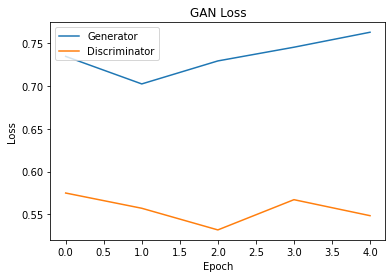

In [6]:
plt.plot(g_loss)
plt.plot(d_loss)
plt.title('GAN Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Generator', 'Discriminator'], loc='upper left')
plt.show()